# RDD

이전 Jupyter Notebook의 내용에 이어서 RDD를 이용한 데이터의 집계를 해보려고 한다.
여러 RDD 연산을 사용하여 데이터를 집계하고 변환하여 유의미하게 데이터를 가공해보자.
해당 Notebook에서는 아래의 내용을 다룬다.

- GroupBy: RDD를 특정 기준으로 그룹화
- Paired RDD: 키-값 쌍으로 구성된 RDD
- groupByKey(): Paired RDD를 키를 기준으로 그룹화하고, 각 그룹에 대한 값들의 Iterable을 생성
- reduceByKey(): Paired RDD를 키를 기준으로 그룹화하고, 각 그룹에 대해 리듀스 함수를 사용하여 값을 집계
- combineByKey(): Paired RDD를 키를 기준으로 그룹화하고, 각 그룹에 대해 초기값, 병합 및 리듀스 함수를 사용하여 값을 집계
- flatmap(): 각 입력 항목에 대해 여러 출력 항목을 생성하는 함수를 적용하여 새로운 RDD를 생성

<br><hr><br>

# RDD를 파일로 Write하기

In [1]:
import os, sys
import pyspark

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/03 15:38:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/03 15:38:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
spark.sparkContext.parallelize([['THIS', 'IS'], ['A', 'LINE']]).saveAsTextFile("data/ds_spark_wiki_out")

In [3]:
os.listdir('data/ds_spark_wiki_out')

['._SUCCESS.crc', '.part-00000.crc', '_SUCCESS', 'part-00000']

In [4]:
_rdd=spark.sparkContext.textFile(os.path.join("data", "ds_spark_wiki_out"))

In [5]:
_rdd.collect()

["['THIS', 'IS']", "['A', 'LINE']"]

### Groupby

groupBy()는 RDD를 변환transformation 함수이다. Paired나 Unpaired 어느 경우에도 사용할 수 있지만, 주로 unpaired RDD에 많이 쓰인다.

Unpaired 데이터는 key, value 쌍으로 구성이 되지 않은 데이터를 말한다. 텍스트를 보면, 그냥 문자열이고 키가 존재하지 않아 Unpaired 형식이다. 또 다른 예는 이름, 전공인데 얼핏보면 이름이 키로 보이지만 문자열 데이터이다.

In [6]:
myRdd2=spark.sparkContext\
    .textFile(os.path.join("data","ds_spark_wiki.txt"))

In [7]:
myRdd2.take(10)

['Wikipedia',
 'Apache Spark is an open source cluster computing framework.',
 '아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다.',
 'Apache Spark Apache Spark Apache Spark Apache Spark',
 '아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크',
 "Originally developed at the University of California, Berkeley's AMPLab,",
 'the Spark codebase was later donated to the Apache Software Foundation,',
 'which has maintained it since.',
 'Spark provides an interface for programming entire clusters with',
 'implicit data parallelism and fault-tolerance.']

In [13]:
myRdd_group=myRdd2.groupBy(lambda x:"아파치" in x)

print(myRdd_group.collect())    


[(False, <pyspark.resultiterable.ResultIterable object at 0x7fad50058700>), (True, <pyspark.resultiterable.ResultIterable object at 0x7fad91d05a00>)]


In [18]:
# 데이터의 집단화 groupBy
# 데이터를 집단화하기 위해서 groupBy() 함수가 필요하고, 그 결과는 그룹명은 key, 구성원은 value로 저장된다.
for (k,v) in myRdd_group.collect():
    print ("{}: {}".format(k, v))

False: <pyspark.resultiterable.ResultIterable object at 0x7fad6046b190>
True: <pyspark.resultiterable.ResultIterable object at 0x7fad6046bd00>


In [19]:
for (k,v) in myRdd_group.collect():
    for eachValue in v:
        print ("{}: {}".format(k, eachValue))
    print ("-----")

False: Wikipedia
False: Apache Spark is an open source cluster computing framework.
False: Apache Spark Apache Spark Apache Spark Apache Spark
False: Originally developed at the University of California, Berkeley's AMPLab,
False: the Spark codebase was later donated to the Apache Software Foundation,
False: which has maintained it since.
False: Spark provides an interface for programming entire clusters with
False: implicit data parallelism and fault-tolerance.
-----
True: 아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다.
True: 아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크
-----


In [20]:
# [] list 
# {} dic 
# () tuple 
# <> object

# Paired RDD
key, value의 쌍 -> 튜플 또는 리스트
- 튜플 : 수정이 불가능, 리스트에 비해 메모리 효율
- 리스트 : 수정이 가능

In [21]:
_tuple=(("Seoul",1),("Seoul",1),("Seoul",1),("Busan",1),("Busan",1),
           ("Seoul",1),("Busan",1),("Bundang",1),("Bundang",1),("Bundang", 1),
           ("Seoul",1),("Seoul",1),("Busan",1),("Busan",1),("Seoul",1))

_list=[["Seoul",1],["Seoul",1],["Seoul",1],["Busan",1],["Busan",1],["Busan",1],
           ["Seoul",1],["Busan",1],["Bundang",1],["Bundang",1],["Bundang",1],
           ["Seoul",1],["Seoul",1],["Busan",1],["Busan",1],["Seoul",1]]

In [22]:
import sys
print("memory size of tuples (bytes): ", sys.getsizeof(_tuple))
print("memory size of lists (bytes): ",sys.getsizeof(_list))

memory size of tuples (bytes):  160
memory size of lists (bytes):  184


### ResultIterable : groupByKey()의 결과는 ResultIterable이고, 이 객체는 그대로 볼 수 없다.

In [24]:
_testRdd=spark.sparkContext.parallelize(_list)
_testRdd.groupBy(lambda x:x[0]).collect()

[('Seoul', <pyspark.resultiterable.ResultIterable at 0x7fad91dcd850>),
 ('Busan', <pyspark.resultiterable.ResultIterable at 0x7fad920efdf0>),
 ('Bundang', <pyspark.resultiterable.ResultIterable at 0x7fad920eff40>)]

### mapValues() : value에 대해서 map 적용

In [25]:
_testRdd.groupBy(lambda x:x[0]).mapValues(lambda x: list(x)).collect()

[('Seoul',
  [['Seoul', 1],
   ['Seoul', 1],
   ['Seoul', 1],
   ['Seoul', 1],
   ['Seoul', 1],
   ['Seoul', 1],
   ['Seoul', 1]]),
 ('Busan',
  [['Busan', 1],
   ['Busan', 1],
   ['Busan', 1],
   ['Busan', 1],
   ['Busan', 1],
   ['Busan', 1]]),
 ('Bundang', [['Bundang', 1], ['Bundang', 1], ['Bundang', 1]])]

### groupByKey보다는 reduceByKey 또는 combineByKey를 사용하는 것을 추천하고 있다. 
groupByKey는 메모리를 많이 사용하고, reduceByKey는 Partition별로 작업이 동시에 병렬적으로 수행될 수 있으므로 보다 빠르기 때문이다.

In [26]:
_testRdd.reduceByKey(lambda x,y:x+y).collect() #연산을 적용시킴

[('Seoul', 7), ('Busan', 6), ('Bundang', 3)]

In [27]:
_testRdd.groupByKey().collect() #키별로 묶어놓음

[('Seoul', <pyspark.resultiterable.ResultIterable at 0x7fad91dcd9d0>),
 ('Busan', <pyspark.resultiterable.ResultIterable at 0x7fad91cfadc0>),
 ('Bundang', <pyspark.resultiterable.ResultIterable at 0x7fad91cfa280>)]

In [28]:
_testRdd.groupByKey().mapValues(list).collect() #Groupby(ResultIterable의 반환값)을 품

[('Seoul', [1, 1, 1, 1, 1, 1, 1]),
 ('Busan', [1, 1, 1, 1, 1, 1]),
 ('Bundang', [1, 1, 1])]

In [29]:
_testRdd.mapValues(lambda x:x+1).collect() #Value에 대해서 lambda식 적용

[('Seoul', 2),
 ('Seoul', 2),
 ('Seoul', 2),
 ('Busan', 2),
 ('Busan', 2),
 ('Busan', 2),
 ('Seoul', 2),
 ('Busan', 2),
 ('Bundang', 2),
 ('Bundang', 2),
 ('Bundang', 2),
 ('Seoul', 2),
 ('Seoul', 2),
 ('Busan', 2),
 ('Busan', 2),
 ('Seoul', 2)]

# 단어빈도 세어보기

In [34]:
myRdd2.collect()

['Wikipedia',
 'Apache Spark is an open source cluster computing framework.',
 '아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다.',
 'Apache Spark Apache Spark Apache Spark Apache Spark',
 '아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크',
 "Originally developed at the University of California, Berkeley's AMPLab,",
 'the Spark codebase was later donated to the Apache Software Foundation,',
 'which has maintained it since.',
 'Spark provides an interface for programming entire clusters with',
 'implicit data parallelism and fault-tolerance.']

In [38]:
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .take(3)

[('Wikipedia', 1), ('Apache', 1), ('Spark', 1)]

In [30]:
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .take(3)

[('Wikipedia', <pyspark.resultiterable.ResultIterable at 0x7fad920dcca0>),
 ('Apache', <pyspark.resultiterable.ResultIterable at 0x7fad60472ac0>),
 ('Spark', <pyspark.resultiterable.ResultIterable at 0x7fad60472e80>)]

In [31]:
# sum은 value에 적용되는 내장함수
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .mapValues(sum)\
    .take(10)

[('Wikipedia', 1),
 ('Apache', 6),
 ('Spark', 7),
 ('is', 1),
 ('an', 2),
 ('open', 1),
 ('source', 1),
 ('cluster', 1),
 ('computing', 1),
 ('framework.', 1)]

In [32]:
def f(x): return len(x)
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .mapValues(f)\
    .sortByKey(True)\
    .take(10)

[('AMPLab,', 1),
 ('Apache', 6),
 ("Berkeley's", 1),
 ('California,', 1),
 ('Foundation,', 1),
 ('Originally', 1),
 ('Software', 1),
 ('Spark', 7),
 ('University', 1),
 ('Wikipedia', 1)]

In [42]:
wc=myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .mapValues(sum)\
    .sortByKey(True)\
    .collect()

#공백으로 구분, 단어빈도를 계산하기 위해, map()은 단어별 빈도 (x,1)를 만듦
#groupByKey()는 key를 묶어준다. 따라서 ResultIterable iterator를 반환한다.
#sortByKey()로 key로 정렬한 후 collect()한다.

for k,v in wc:
    print (f"단어:{k}\t\t빈도:{v}")

단어:AMPLab,		빈도:1
단어:Apache		빈도:6
단어:Berkeley's		빈도:1
단어:California,		빈도:1
단어:Foundation,		빈도:1
단어:Originally		빈도:1
단어:Software		빈도:1
단어:Spark		빈도:7
단어:University		빈도:1
단어:Wikipedia		빈도:1
단어:an		빈도:2
단어:and		빈도:1
단어:at		빈도:1
단어:cluster		빈도:1
단어:clusters		빈도:1
단어:codebase		빈도:1
단어:computing		빈도:1
단어:data		빈도:1
단어:developed		빈도:1
단어:donated		빈도:1
단어:entire		빈도:1
단어:fault-tolerance.		빈도:1
단어:for		빈도:1
단어:framework.		빈도:1
단어:has		빈도:1
단어:implicit		빈도:1
단어:interface		빈도:1
단어:is		빈도:1
단어:it		빈도:1
단어:later		빈도:1
단어:maintained		빈도:1
단어:of		빈도:1
단어:open		빈도:1
단어:parallelism		빈도:1
단어:programming		빈도:1
단어:provides		빈도:1
단어:since.		빈도:1
단어:source		빈도:1
단어:the		빈도:3
단어:to		빈도:1
단어:was		빈도:1
단어:which		빈도:1
단어:with		빈도:1
단어:소스		빈도:1
단어:스파크		빈도:4
단어:스파크는		빈도:1
단어:아파치		빈도:5
단어:오픈		빈도:1
단어:컴퓨팅		빈도:1
단어:클러스터		빈도:1
단어:프레임워크이다.		빈도:1


### CountByKey 이용하기

In [43]:
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .countByKey() # .items() to be added to get a list

defaultdict(int,
            {'Wikipedia': 1,
             'Apache': 6,
             'Spark': 7,
             'is': 1,
             'an': 2,
             'open': 1,
             'source': 1,
             'cluster': 1,
             'computing': 1,
             'framework.': 1,
             '아파치': 5,
             '스파크는': 1,
             '오픈': 1,
             '소스': 1,
             '클러스터': 1,
             '컴퓨팅': 1,
             '프레임워크이다.': 1,
             '스파크': 4,
             'Originally': 1,
             'developed': 1,
             'at': 1,
             'the': 3,
             'University': 1,
             'of': 1,
             'California,': 1,
             "Berkeley's": 1,
             'AMPLab,': 1,
             'codebase': 1,
             'was': 1,
             'later': 1,
             'donated': 1,
             'to': 1,
             'Software': 1,
             'Foundation,': 1,
             'which': 1,
             'has': 1,
             'maintained': 1,
             'it': 1,
      

# 파일의 단어빈도 세어보기

In [44]:
%%writefile data/ds_bigdata_wiki.txt
Big data
활용사례 및 의의[편집]
정치 및 사회[편집]
2008년 미국 대통령 선거[편집]
2008년 미국 대통령 선거에서 버락 오바마 미국 대통령 후보는 다양한 형태의 유권자 데이터베이스를 확보하여 이를 분석, 활용한 '유권자 맞춤형 선거 전략'을 전개했다. 당시 오바마 캠프는 인종, 종교, 나이, 가구형태, 소비수준과 같은 기본 인적 사항으로 유권자를 분류하는 것을 넘어서서 과거 투표 여부, 구독하는 잡지, 마시는 음료 등 유권자 성향까지 전화나 개별 방문을 또는 소셜 미디어를 통해 유권자 정보를 수집하였다. 수집된 데이터는 오바마 캠프 본부로 전송되어 유권자 데이터베이스를 온라인으로 통합관리하는 ‘보트빌더(VoteBuilder.com)’시스템의 도움으로 유권자 성향 분석, 미결정 유권자 선별 , 유권자에 대한 예측을 해나갔다. 이를 바탕으로‘유권자 지도’를 작성한 뒤 ‘유권자 맞춤형 선거 전략’을 전개하는 등 오바마 캠프는 비용 대비 효과적인 선거를 치를 수 있었다.

대한민국 제19대 총선[편집]
중앙선거관리위원회는 대한민국 제19대 총선부터 소셜 네트워크 등 인터넷 상의 선거 운동을 상시 허용하였다.[15] 이에 소셜 미디어 상에서 선거 관련 데이터는 증폭되었으며, 2010년 대한민국 제5회 지방 선거 및 2011년 대한민국 재보궐선거에서 소셜 네트워크 서비스의 중요성을 확인한 정당들 또한 SNS 역량 지수를 공천 심사에 반영하는 등[16] 소셜 네트워크 활용에 주목했다. 이 가운데 여론 조사 기관들은 기존 여론조사 방식으로 예측한 2010년 제5회 지방 선거 및 2011년 재보궐선거의 여론조사 결과와 실제 투표 결과와의 큰 차이를 보완하고자 빅 데이터 기술을 활용한 SNS 여론 분석을 시행했다. 그러나 SNS 이용자의 대다수가 수도권 20~30대에 쏠려 있기에[17], 빅 데이터를 이용한 대한민국 제19대 총선에 대한 SNS 분석은 수도권으로 한정되어 일치하는 한계를 드러내기도 하였다.

경제 및 경영[편집]
아마존닷컴의 추천 상품 표시 / 구글 및 페이스북의 맞춤형 광고[편집]
아마존닷컴은 모든 고객들의 구매 내역을 데이터베이스에 기록하고, 이 기록을 분석해 소비자의 소비 취향과 관심사를 파악한다.[18] 이런 빅 데이터의 활용을 통해 아마존은 고객별로 '추천 상품(레코멘데이션)'을 표시한다. 고객 한사람 한사람의 취미나 독서 경향을 찾아 그와 일치한다고 생각되는 상품을 메일, 홈 페이지상에서 중점적으로 고객 한사람 한사람에게 자동적으로 제시하는 것이다.[19] 아마존닷컴의 추천 상품 표시와 같은 방식으로 구글 및 페이스북도 이용자의 검색 조건, 나아가 사진과 동영상 같은 비정형 데이터 사용을 즉각 처리하여 이용자에게 맞춤형 광고를 제공하는 등 빅데이터의 활용을 증대시키고 있다.

문화[편집]
MLB (메이저 리그 베이스볼)의 머니볼 이론 및 데이터 야구[편집]
머니볼 이론이란 경기 데이터를 철저하게 분석해 오직 데이터를 기반으로 적재적소에 선수들을 배치해 승률을 높인다는 게임 이론이다.[20] 이는 미국 메이저 리그 베이스볼 오클랜드 어슬레틱스의 구단장 빌리 빈이 리그 전체 25위에 해당하는 낮은 구단 지원금 속에서도 최소비용으로 최대효과를 거둔 상황에서 유래되었다. 빌리 빈은 하치해 최하위에 그치던 팀을 4년 연속 포스트시즌에 진출시키고 메이저 리그 최초로 20연승이라는 신기록을 세우도록 탈바꿈 시켰다. 미국 월스트리트 저널은 미국 경제에 큰 영향을 끼치는 파워 엘리트 30인에 워렌 버핏, 앨런 그린스펀과 함께 빌리 빈을 선정[21] 하는 등 머니볼 이론은 경영, 금융 분야에서도 주목받았다. 최근 들어서 과학기술 및 카메라 기술의 발달로 더욱 정교한 데이터의 수집이 가능해졌으며 투구의 궤적 및 투수의 그립, 타구 방향, 야수의 움직임까지 잡아낼 수 있게 되었다. 이처럼 기존의 정형 데이터뿐만 아닌 비정형 데이터의 수집과 분석, 활용을 통해 최근 야구경기에서 빅 데이터의 중요성은 더욱 커지고 있다.

선수의 인기만을 쫓는 것이 아니라 팀별 승률이나 선수의 성적을 나타내는 수치와 야구를 관전한다면 그 재미는 배가된다. '출루율'은 타율로 인정되지 않는 볼넷을 포함하여 타자가 성공적으로 베이스를 밟은 횟수의 비율, '장타율'은 타수마다 밟은 총 베이스를 계산해서 타격력이 얼마나 강한지를 나타내는 비율이다.

출루율과 장타율 못지 않게 '타수'는 한두 경기에서 낸 성적이 아닌, 수천 번의 타석에 들어 좋은 성적을 만들어낸 선수를 선별하기 위한 기초 통계자료이다. 이처럼 한 선수의 타율에서 팀의 역대 시리즈 전적까지 모든 것을 숫자로 표현할 수 있다고 해서 야구를 '통계의 스포츠'라고 부르기도 한다. 야구뿐만 아니라 생활 곳곳에서 활용되는 통계는 복잡한 상황과 설명을 간단한 숫자로 바꿔주는 매우 강력한 도구이다.[22]

'프로파일링'과 '빅데이터' 기법을 활용한 프로그램 MBC <프로파일링>[편집]
방송에는 19세 소년의 살인 심리를 파헤친 '용인살인사건의 재구성', 강남 3구 초등학교 85곳의 학업성취도평가 성적과 주변 아파트 매매가의 상관관계를 빅데이터(디지털 환경에서 발생한 방대한 규모의 데이터)를 통해 분석한 '강남, 부자일수록 공부를 잘할까'[23]

2014년 FIFA 월드컵 독일 우승과 '빅데이터'[편집]
브라질에서 개최된 2014년 FIFA 월드컵에서 독일은 준결승에서 개최국인 브라질을 7:1로 꺾고, 결승에서 아르헨티나와 연장전까지 가는 접전 끝에 1:0으로 승리를 거두었다. 무패행진으로 우승을 차지한 독일 국가대표팀의 우승의 배경에는 '빅데이터'가 있었다.

독일 국가대표팀은 SAP와 협업하여 훈련과 실전 경기에 'SAP 매치 인사이트'를 도입했다. SAP 매치 인사이트란 선수들에게 부착된 센서를 통해 운동량, 순간속도, 심박수, 슈팅동작 등 방대한 비정형 데이터를 수집, 분석한 결과를 감독과 코치의 태블릿PC로 전송하여 그들이 데이터를 기반으로 전술을 짜도록 도와주는 솔루션이다. 기존에 감독의 경험이나 주관적 판단으로 결정되는 전략과는 달리, SAP 매치 인사이트를 통해 이루어지는 분석은 선수들에 대한 분석 뿐만 아니라 상대팀 전력, 강점, 약점 등 종합적인 분석을 통해 좀 더 과학적인 전략을 수립할 수 있다. 정보 수집에 쓰이는 센서 1개가 1분에 만들어내는 데이터는 총 12000여개로 독일 국가대표팀은 선수당 4개(골키퍼는 양 손목을 포함해 6개)의 센서를 부착했고, 90분 경기동안 한 선수당 약 432만개, 팀 전체로 약 4968만개의 데이터를 수집했다고 한다.월드컵8강 獨 전차군단 비밀병기는 '빅데이터'

과학기술 및 활용[편집]
통계학[편집]
데이터 마이닝이란 기존 데이터베이스 관리도구의 데이터 수집, 저장, 관리, 분석의 역량을 넘어서는 대량의 정형 또는 비정형 데이터 집합 및 이러한 데이터로부터 가치를 추출하고 결과를 분석하는 기술로, 수집되는 ‘빅 데이터’를 보완하고 마케팅, 시청률조사, 경영 등으로부터 체계화돼 분류, 예측, 연관분석 등의 데이터 마이닝을 거쳐 통계학적으로 결과를 도출해 내고 있다.[24][25]

대한민국에서는 2000년부터 정보통신부의 산하단체로 사단법인 한국BI데이터마이닝학회가 설립되어 데이터 마이닝에 관한 학술과 기술을 발전, 보급, 응용하고 있다. ‎또한 국내ㆍ외 통계분야에서 서서히 빅 데이터 활용에 대한 관심과 필요성이 커지고 있는 가운데 국가통계 업무를 계획하고 방대한 통계자료를 처리하는 국가기관인 통계청이 빅 데이터를 연구하고 활용방안을 모색하기 위한 '빅 데이터 연구회'를 발족하였다.[26] 하지만 업계에 따르면, 미국과 영국, 일본 등 선진국들은 이미 빅 데이터를 다각적으로 분석해 조직의 전략방향을 제시하는 데이터과학자 양성에 사활을 걸고 있다. 그러나 한국은 정부와 일부 기업이 데이터과학자 양성을 위한 프로그램을 진행 중에 있어 아직 걸음마 단계인 것으로 알려져 있다.[27]

생물정보학[편집]
최근 생물학에서 DNA, RNA, 단백질 서열 및 유전자들의 발현과 조절에 대한 데이터의 양이 급격히 증가했고 이에 따라 이 빅 데이터를 활용한 생명의 이해에 관한 논의가 진행되고 있다.

보건의료[편집]
국민건강보험공단은 가입자의 자격·보험료, 진료·투약내용, 건강검진 결과 및 생활습관 정보 등 2조1천억건, 92테라바이트의 빅데이터를 보유하고 있고, 한편, 건강보험심사평가원은 진료내역, 투약내용(의약품 안심서비스), 의약품 유통 등의 2조2천억건, 89테라바이트의 빅데이터를 보유하고 있으며, 경제협력개발기구(OECD)는 한국의 건강보험 빅데이터 순위가 2위라고 발표했었다. 건보공단과 심평원은 빅데이터를 민간에 널리 알리고 더 많이 개방하고 있다. (연합뉴스 2016.6.14 인터넷뉴스 참조)

빅 데이터를 활용하면 미국 의료부문은 연간 3,300 억 달러(미 정부 의료 예산의 약 8%에 해당하는 규모)의 직간접적인 비용 절감 효과를 보일 것으로 전망된다.[28] 특히 임상분야에서는 의료기관 별 진료방법, 효능, 비용 데이터를 분석하여 보다 효과적인 진료방법을 파악하고 환자 데이터를 온라인 플랫폼화하여 의료협회 간 데이터 공유로 치료 효과를 제고하며 공중보건 영역에선 전국의 의료 데이터를 연계하여 전염병 발생과 같은 긴박한 순간에 빠른 의사결정을 가능케 할 전망이다.[29]

한편, 의료 분야에서 빅 데이터가 효과를 발휘하기 위해서는 대량의 의료정보 수집이 필수적이기 때문에, 개인정보의 보호와 빅 데이터 활용이라는 두 가지 가치가 상충하게 되된다. 따라서, 의료 분야에서 빅 데이터의 활용과 보급을 위해서는 이러한 문제에 대한 가이드라인 마련이 필요한 상태이다.[30]

기업 경영[편집]
대규모의 다양한 데이터를 활용한 '빅데이터 경영'이 주목받으면서 데이터 품질을 높이고 방대한 데이터의 처리를 돕는 데이터 통합(Data Integration)의 중요성이 부각되고 있다.

데이터 통합(DI)은 데이터의 추출, 변환, 적재를 위한 ETL 솔루션이 핵심인데 ETL 솔루션을 활용하면 일일이 수많은 데이터를 기업 데이터 포맷으로 코딩하지 않아도 되고 데이터 품질을 제고할 수 있기 때문에 DI는 빅데이터 환경에 꼭 필요한 데이터 솔루션으로 평가받고 있는 단계까지 진입되었다.

한편 비즈니스 인텔리전스(Business Intelligence, BI)보다 진일보한 빅데이터 분석 방법이 비즈니스 애널리틱스(Business analytics, BA)인데 고급분석 범주에 있는 BA는 기본적으로 BI를 포함하면서도 미래 예측 기능과 통계분석, 확률 분석 등을 포함해 최적의 데이터 기반 의사결정을 가능케 하는 것으로 평가받고 있기도 하다.[31]

마케팅[편집]
인터넷으로 시작해서 인터넷으로 마감하는 생활, 스마트폰을 이용해 정보를 검색하고 쇼핑도하고 SNS를 이용해서 실시간으로 글을 남기는 등의 다양하게 인터넷을 이용하는 동안 남는 흔적같은 모인 데이터들을 분석하면 개인의 생활 패턴, 소비성향 등을 예측할 수 있고 기업들은 이런 데이터를 통해서 소비자가 원하는 것들을 미리 예측할 수 있다. 빅 데이터가 마케팅 자료로 활용되는 사례이다.[31]

기상정보[편집]
한반도 전역의 기상관측정보를 활용해 일기예보와 각종 기상특보 등 국가 기상서비스를 제공하고 있는 기상청은 정밀한 기상예측을 위한 분석 과정에서 발생하는 데이터 폭증에 대응하고자 빅데이터 저장시스템의 도입을 추진하였다.

대다수 스토리지 기업들의 솔루션을 검토한 끝에 한국 IBM의 고성능 대용량 파일공유시스템(General Parallel File System, 이하 GPFS)을 적용한 스토리지 시스템을 선택하였다고 밝혔다.

한국IBM이 기상청에 제공한 GPFS 기반의 빅데이터 저장시스템은 IBM 시스템 스토리지 제품군, 시스템 x서버 제품군과 고속 네트워킹 랙스위치(RackSwitch) 등이 통합돼 있는 시스템이다.[31]

보안관리[편집]
보안관리는 빅데이터 환경을 이용해 성장과 기술 발전을 동시에 이루는 분야로 분리한다. 클라우드 및 모바일 환경으로 접어들면서 물리/가상화 IT 시스템의 복잡성이 더욱 높아지고 있어 유무선 네트워크, 프라이빗/퍼블릭 클라우드, 모바일 애플리케이션과 기기관리 등 IT 시스템 전반에서 대대적인 변화가 예상되고 있어 막대한 양의 보안관리가 중요한 요소로 현실화되고 있다.[32]

구글 번역[편집]
구글에서 제공하는 자동 번역 서비스인 구글 번역은 빅 데이터를 활용한다. 지난 40년 간 컴퓨터 회사 IBM의 자동 번역 프로그램 개발은 컴퓨터가 명사, 형용사, 동사 등

Writing data/ds_bigdata_wiki.txt


### 불용어 라이브러리

In [50]:
# Python nltk 라이브러리에서 제공하는 불용어를 사용하거나

# from nltk.corpus import stopwords
# englishStops = set(stopwords.words('english'))



In [51]:
# 또는 skleran 라이브러리를 활용해도 된다.
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
'the' in ENGLISH_STOP_WORDS # true

True

### 파이썬으로 단어빈도 세어보기

In [52]:
# 한글 불용어는 불행히도 아직 제공되고 있지 못하여, 우리 스스로 임의로 만들어 쓰도록 하자
stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])

In [57]:
import os

d = dict()

# 인코딩 지정
with open(os.path.join("data", "ds_bigdata_wiki.txt"), 'r', encoding='utf-8') as f:
    for sent in f.readlines():
        _words = sent.split()  # split into words
        for word in _words:
            if word not in stopwords: # remove stopwords
                if word not in d:
                    d[word]=1
                else:
                    d[word]=d[word]+1

In [58]:
d

{'Big': 1,
 'data': 1,
 '활용사례': 1,
 '의의[편집]': 1,
 '정치': 1,
 '사회[편집]': 1,
 '2008년': 2,
 '미국': 7,
 '대통령': 3,
 '선거[편집]': 1,
 '선거에서': 1,
 '버락': 1,
 '오바마': 4,
 '후보는': 1,
 '다양한': 2,
 '형태의': 1,
 '유권자': 6,
 '데이터베이스를': 2,
 '확보하여': 1,
 '분석,': 3,
 '활용한': 5,
 "'유권자": 1,
 '맞춤형': 4,
 '선거': 6,
 "전략'을": 1,
 '전개했다.': 1,
 '당시': 1,
 '캠프는': 2,
 '인종,': 1,
 '종교,': 1,
 '나이,': 1,
 '가구형태,': 1,
 '소비수준과': 1,
 '같은': 4,
 '기본': 1,
 '인적': 1,
 '사항으로': 1,
 '유권자를': 1,
 '분류하는': 1,
 '것을': 2,
 '넘어서서': 1,
 '과거': 1,
 '투표': 2,
 '여부,': 1,
 '구독하는': 1,
 '잡지,': 1,
 '마시는': 1,
 '음료': 1,
 '성향까지': 1,
 '전화나': 1,
 '개별': 1,
 '방문을': 1,
 '소셜': 5,
 '미디어를': 1,
 '통해': 7,
 '정보를': 2,
 '수집하였다.': 1,
 '수집된': 1,
 '데이터는': 3,
 '캠프': 1,
 '본부로': 1,
 '전송되어': 1,
 '온라인으로': 1,
 '통합관리하는': 1,
 '‘보트빌더(VoteBuilder.com)’시스템의': 1,
 '도움으로': 1,
 '성향': 1,
 '미결정': 1,
 '선별': 1,
 ',': 1,
 '유권자에': 1,
 '대한': 6,
 '예측을': 1,
 '해나갔다.': 1,
 '바탕으로‘유권자': 1,
 '지도’를': 1,
 '작성한': 1,
 '뒤': 1,
 '‘유권자': 1,
 '전략’을': 1,
 '전개하는': 1,
 '비용': 3,
 '대비': 1,
 '효과적인': 2,
 '선거를': 1,
 '치를': 1

## PySpark로 단어빈도 세어보기

In [59]:
myRdd3=spark.sparkContext\
    .textFile(os.path.join("data","ds_bigdata_wiki.txt"))

### flatMap vs map
flatMap()은 리스트안에 또 리스트가 있는 경우 이를 하나의 리스트로 만든다. 반면에 map()은 리스트 안에 또 리스트가 있는 구조를 보존하고 처리한다. 다음에서 보듯이 flatMap()은 모든 단어를 하나의 리스트로 만들고 있다. 그러나 map() 파일의 줄마다 리스트를 만든다.

In [60]:
wc3=myRdd3\
    .flatMap(lambda x:x.split())\
    .take(10)

In [61]:
for i in wc3:
    print (i, end='/')

Big/data/활용사례/및/의의[편집]/정치/및/사회[편집]/2008년/미국/

In [63]:
# 불용어 제거
stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])
wc3_stop1 = myRdd3\
    .flatMap(lambda x: x.split())\
    .filter(lambda x: x.lower() not in stopwords)\
    .take(10)

In [64]:
for i in wc3_stop1:
    print (i, end='/')

Big/data/활용사례/의의[편집]/정치/사회[편집]/2008년/미국/대통령/선거[편집]/

In [65]:
# Map
wc3=myRdd3\
    .map(lambda x:(x,1))\
    .take(3)
for i in wc3:
    print (i, end='/')

('Big data', 1)/('활용사례 및 의의[편집]', 1)/('정치 및 사회[편집]', 1)/

In [66]:
# FlatMap
# 파일 전체를 (flat해서) map. flat하지 않으면 줄바꿈으로 구분함.
wc3=myRdd3\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .take(10)
for i in wc3:
    print (i, end='/')

('Big', 1)/('data', 1)/('활용사례', 1)/('및', 1)/('의의[편집]', 1)/('정치', 1)/('및', 1)/('사회[편집]', 1)/('2008년', 1)/('미국', 1)/

In [67]:
wc3=myRdd3\
    .flatMap(lambda x:x.split())\
    .filter(lambda x: x.lower() not in stopwords)\
    .map(lambda x:(x,1))\
    .reduceByKey(lambda x,y:x+y)\
    .map(lambda x:(x[1],x[0]))\
    .sortByKey(False)\
    .take(15)

In [68]:
wc3

[(20, '데이터'),
 (17, '데이터를'),
 (14, '빅'),
 (9, '있다.'),
 (8, '데이터의'),
 (7, '미국'),
 (7, '통해'),
 (7, '수'),
 (6, '유권자'),
 (6, '선거'),
 (6, '대한'),
 (6, '빅데이터'),
 (5, '활용한'),
 (5, '소셜'),
 (5, '대한민국')]

## 시각화

In [69]:
k=list()
v=list()
for i in wc3:
    v.append(i[0])
    k.append(i[1])

findfont: Font family ['San Francisco'] not found. Falling back to DejaVu Sans.


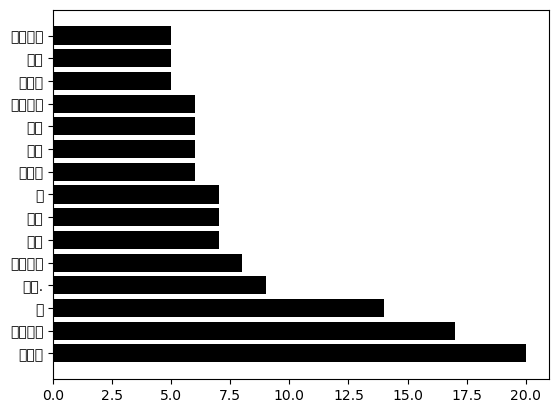

In [75]:
import matplotlib.pyplot as plt
plt.rc('font', family='San Francisco')
plt.barh(range(len(v)), v, color = 'black')  # x <- from (v)alues
plt.yticks(range(len(v)), k)                 # y <- from (k)eys
plt.show()

### CombineByKey 
sum과 count를 구하기 위해서 사용한다.
combiner, merge values, merge combiner의 인자

createCombiner: 첫 번째 함수는 각 키에 대한 초기 값 또는 "초기 결합 요소"를 생성하는 데 사용됩니다. 즉, 새로운 키가 나타날 때 초기 값을 설정하는 함수입니다. 이 함수는 각 요소에 대해 딱 한 번 호출됩니다.

mergeValue: 두 번째 함수는 기존 값과 새로운 값을 병합하는 데 사용됩니다. 같은 키에 대해 여러 값이 있을 때 호출되며, 해당 키의 중간 결과를 업데이트하고자 할 때 유용합니다.

mergeCombiners: 세 번째 함수는 서로 다른 파티션에서 나온 중간 결과를 병합하는 데 사용됩니다. 즉, 여러 파티션에서 계산된 중간 결과를 하나로 합치는 함수입니다.

In [76]:
_list1=[("key1",1),("key1",3),("key2",2),("key1",2),("key2",4),
           ("key1",5),("key2",6),
           ("key1",7),("key1",8),("key2",9),("key2",3)]

In [77]:
_testRdd1=spark.sparkContext.parallelize(_list1)

In [78]:
# key1의 첫째 값은 1이다. 이경우 combiner (*표기), 다음은 merge values (# 표기)로 계산이 된다. 
# 따라서 1*#3#2#5#7#8가 출력된다.
_testRdd1.combineByKey(lambda v : str(v)+"*", lambda c, v : c+"#"+str(v), lambda c1, c2 : c1+'&'+c2).collect()

[('key1', '1*#3#2#5#7#8'), ('key2', '2*#4#6#9#3')]

In [79]:
# partition이 복수인 경우에는 mergeCombiner가 작동한다. 먼저 partition을 2개로 해서 Rdd를 생성하자.
_testRdd2=spark.sparkContext.parallelize(_list1, 2)
partitions = _testRdd2.glom().collect()
for num, partition in enumerate(partitions):
    print(f'Partitions {num} -> {partition}')

Partitions 0 -> [('key1', 1), ('key1', 3), ('key2', 2), ('key1', 2), ('key2', 4)]
Partitions 1 -> [('key1', 5), ('key2', 6), ('key1', 7), ('key1', 8), ('key2', 9), ('key2', 3)]


In [80]:
# merge combiner(&)로 표기된다.
_testRdd2.combineByKey(lambda v : str(v)+"*", lambda c, v : c+"#"+str(v), lambda c1, c2 : c1+'&'+c2).collect()

[('key1', '1*#3#2&5*#7#8'), ('key2', '2*#4&6*#9#3')]

## 직접 해보기

In [81]:
_testRdd1.combineByKey(lambda value: (value,1),
                     lambda x,value: (x[0]+value, x[1]+1),
                     lambda x,y: (x[0]+y[0], x[1]+y[1])) \
        .collect()

[('key1', (26, 6)), ('key2', (24, 5))]

In [82]:
# 평균 계산

_testCbkRdd=_testRdd1.combineByKey(lambda value: (value,1),
                     lambda x,value: (x[0]+value, x[1]+1),                      
                     lambda x,y: (x[0]+y[0], x[1]+y[1]))

In [83]:
averageByKey = _testCbkRdd.map(lambda x:(x[0],x[1][0]/x[1][1]))
averageByKey.collectAsMap()

{'key1': 4.333333333333333, 'key2': 4.8}

# 문제 S-3: 성적 합계 및 평균.

아래 데이터를 RDD로 만들고, 성적의 합계 및 평균을 계산하세요. 하위 문제별로 RDD를 생성하지 말고, 원본데이터에서 하나의 RDD만을 생성하고, 이를 변형해서 문제를 푸세요.

In [87]:
marks=[
    "'김하나','English', 100",
    "'김하나','Math', 80",
    "'임하나','English', 70",
    "'임하나','Math', 100",
    "'김갑돌','English', 82.3",
    "'김갑돌','Math', 98.5"
]

In [91]:
_marksRdd=spark.sparkContext.parallelize(marks)
_marksRdd.collect()

["'김하나','English', 100",
 "'김하나','Math', 80",
 "'임하나','English', 70",
 "'임하나','Math', 100",
 "'김갑돌','English', 82.3",
 "'김갑돌','Math', 98.5"]

# 문제 3-1

개인별 데이터를 컴마로 분리하고, 이름 x[0]과 성적 x[2]만 꺼내어 reduceBykey()를 구하면 합계를 구할 수 있다. 여기서 중요한 것은 기존 데이터에서 필요한 이름, 성적만을 꺼내어 처리한다는 점이다.

문제 3-1: 이름으로 합계를 구해보자. 올바른 출력은 다음과 같다.
이름과 점수로 데이터를 추출하고, 이름별로 (이름을 키로) 합계를 계산한다.

In [94]:
_marksbyname=_marksRdd\
    .map(lambda x:x.split(','))\
    .map(lambda x: (x[0],float(x[2])))\
    .reduceByKey(lambda x,y:x+y)\
    .collect()

#분리 -> 0번째, 2번째만 취함 -> reduceByKey로 key에 따른 연산 수행

_marksbyname

[("'김하나'", 180.0), ("'임하나'", 170.0), ("'김갑돌'", 180.8)]

# 문제 3-2

과목과 점수로 데이터를 추출하여, 과목별로 (과목을 키로) 합계를 계산한다.

개인별 데이터를 컴마로 분리하고, 과목 x[1]과 성적 x[2]만 꺼내어 reduceBykey()를 구하면 합계를 구할 수 있다.

In [95]:
# 컴마로 분리하기

_marksRdd\
    .map(lambda x:x.split(','))\
    .collect()

[["'김하나'", "'English'", ' 100'],
 ["'김하나'", "'Math'", ' 80'],
 ["'임하나'", "'English'", ' 70'],
 ["'임하나'", "'Math'", ' 100'],
 ["'김갑돌'", "'English'", ' 82.3'],
 ["'김갑돌'", "'Math'", ' 98.5']]

In [97]:
# 과목과 점수만 분리하기

_marksRdd\
    .map(lambda x:x.split(','))\
    .map(lambda x: (x[1],float(x[2])))\
    .collect()

[("'English'", 100.0),
 ("'Math'", 80.0),
 ("'English'", 70.0),
 ("'Math'", 100.0),
 ("'English'", 82.3),
 ("'Math'", 98.5)]

In [134]:
# CombineByKey 적용

# 다음으로 어떤 함수를 적용하면 될까? 과목별 합계는 reduce를 하면된다. 
# 합계, 개수를 구한다고 combineByKey를 적용하면 어떻게 될까? 
# float 타입으로 combineByKey를 하면 'float' object is not subscriptable 오류가 발생한다. 
# 그렇다고 str으로 한다고 해서 문제가 풀리는 것은 아니다.  combineByKey 함수는 합계를 계산할 수 없기 때문에 최종 값만 남기게 된다.
marks = _marksRdd\
    .map(lambda x:x.split(','))\
    .map(lambda x: (x[1],str(x[2])))

    
marks.combineByKey(lambda value: (value,1),
                  lambda x, value: str(x[0]) + str(value),
                  lambda x, y: x+y)\
    .collect()
    


[("'English'", '  82.3'), ("'Math'", '  98.5')]

In [105]:
# ReduceByKey

# _marksRdd\
#     .map(lambda x:x.split(','))\
#     .map(lambda x: (x[1],str(x[2])))\
#     .collect()

_marksRdd\
    .map(lambda x:x.split(','))\
    .map(lambda x: (x[1],float(x[2])))\
    .reduceByKey(lambda x,y:x+y)\
    .collect()

[("'English'", 252.3), ("'Math'", 278.5)]

# 문제 3-3
합계, 개수를 계산해 보자. combineByKey()를 이용해서 계산해야 한다. 먼저 데이터를 이름, 과목, 데이터 -> 이름, 점수로 변경한다.

이름으로 합계과 개수를 구해보자. 출력은 다음과 같이 계산된다.
이름과 점수로 데이터를 추출하여, 이름별로 (이름을 키로) 합계와 개수를 계산한다.

In [101]:
_marksbyname2=_marksRdd\
    .map(lambda x:x.split(','))\
    .map(lambda x: (x[0],float(x[2])))

sum_counts = _marksbyname2.combineByKey(
    (lambda x: (x, 1)), # the initial value, with value x and count 1
    (lambda acc, value: (acc[0]+value, acc[1]+1)), # how to combine a pair value with the accumulator: sum value, and increment count
    (lambda acc1, acc2: (acc1[0]+acc2[0], acc1[1]+acc2[1])) # combine accumulators
)

for i in sum_counts.collect():
    for each in i:
        print (each, end=' ')
    print()

'김하나' (180.0, 2) 
'임하나' (170.0, 2) 
'김갑돌' (180.8, 2) 


# 문제 3-4

개인별 평균은 3-3에서 구했던 합계, 개수를 사용하여 계산한다. 평균을 계산하기 위해 float() 형변환을 해주었다.

이름으로 평균을 계산해 보자. 앞서 3-3에서 사용했던 결과를 활용하고, 올바른 출력은 다음과 같다.

In [102]:
averageByKey = sum_counts\
    .map(lambda x: (x[0],x[1][0]/x[1][1]))\
    .collect()
for i in averageByKey:
    for j in i:
        print (j, end=' ')
    print()

'김하나' 90.0 
'임하나' 85.0 
'김갑돌' 90.4 
